##  1. Carga del dataset y limpieza de texto
(Mismo bloque que en el notebook 02, reutilizando la función limpiar_texto())

In [414]:
import pandas as pd
import tensorflow as tf
import re
import nltk

# Descargar stopwords (palabras vacías comunes en inglés)
nltk.download('stopwords')
from nltk.corpus import stopwords

# =====================
# 1. Cargar dataset original
# =====================
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
csv_path = tf.keras.utils.get_file("twitter_sentiment.csv", url)
df = pd.read_csv(csv_path)

# =====================
# 2. Preparar stopwords
# =====================
stop_words = set(stopwords.words('english'))  # Lista de palabras comunes que se eliminarán (ej: "the", "and", etc.)

# =====================
# 3. Función para limpiar texto
# =====================
def limpiar_texto(texto):
    texto = texto.lower()  # 🔤 Convierte todo el texto a minúsculas
    texto = re.sub(r'http\S+', '', texto)  # 🌐 Elimina URLs (http://...)
    texto = re.sub(r'@\w+', '', texto)     # 👤 Elimina menciones de usuarios (@usuario)
    texto = re.sub(r'#\w+', '', texto)     # 🏷️ Elimina hashtags (#tema)
    texto = re.sub(r'[^\x00-\x7F]+', ' ', texto)  # 🚫 Elimina caracteres no ASCII (emojis, letras raras)
    texto = re.sub(r'[^\w\s]', '', texto)  # ✂️ Elimina signos de puntuación
    texto = re.sub(r'\d+', '', texto)      # 🔢 Elimina números
    texto = re.sub(r'\s+', ' ', texto).strip()  # 🧹 Reemplaza múltiples espacios por uno solo y recorta bordes
    palabras = texto.split()  # 📦 Divide el texto en palabras individuales (tokens)
    palabras_filtradas = [p for p in palabras if p not in stop_words]  # ❌ Elimina las stopwords
    return ' '.join(palabras_filtradas)  # 🔁 Reconstruye el texto limpio sin stopwords

# =====================
# 4. Aplicar limpieza al dataset
# =====================
df['tweet_limpio'] = df['tweet'].apply(limpiar_texto)  # Aplica la función a cada tweet

# =====================
# 5. Filtrar tweets muy cortos (menos de 3 caracteres)
# =====================
df = df[df['tweet_limpio'].str.len() > 2]  # 🧽 Elimina tweets vacíos o muy cortos después de limpiar

# ✅ El dataframe "df" ahora contiene una columna "tweet_limpio" con texto limpio y listo para NLP


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\herny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [415]:
df['label'].value_counts().rename_axis('Label').reset_index(name='Cantidad')

,Label,Cantidad
0,0,29172
1,1,2231


In [416]:
df.head()

,id,label,tweet,tweet_limpio
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks credit cant use cause dont offer wheelc...
2,3,0,bihday your majesty,bihday majesty
3,4,0,#model i love u take with u all the time in ...,love u take u time ur
4,5,0,factsguide: society now #motivation,factsguide society


##  2. Tokenización y preparación

In [417]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
max_len = 150
oov_token = "<OOV>"# ['<PAD>', '<UNK>', '<OOV>']#, '<BOS>', '<EOS>'] 

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

#tweet_limpio o tweet_sin_stopwords
tokenizer.fit_on_texts(df['tweet_limpio'])
sequences = tokenizer.texts_to_sequences(df['tweet_limpio'])

# tweet_sin_stopwords
#tokenizer.fit_on_texts(df['tweet_sin_stopwords'])
#sequences = tokenizer.texts_to_sequences(df['tweet_sin_stopwords'])

#tokenizer.fit_on_texts(df['tweet'])
#sequences = tokenizer.texts_to_sequences(df['tweet'])
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [418]:
df['tweet_limpio'].sample(10)
print(f"Cantidad de palabras en el tokenizer: {len(tokenizer.word_index)}")
for i in range(5):
    print("Original:", df['tweet'].iloc[i])
    print("Limpio:  ", df['tweet_limpio'].iloc[i])
    print("---")


Cantidad de palabras en el tokenizer: 22635
Original:  @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Limpio:   father dysfunctional selfish drags kids dysfunction
---
Original: @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
Limpio:   thanks credit cant use cause dont offer wheelchair vans pdx
---
Original:   bihday your majesty
Limpio:   bihday majesty
---
Original: #model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
Limpio:   love u take u time ur
---
Original:  factsguide: society now    #motivation
Limpio:   factsguide society
---


## 3. Modelo LSTM con Dropout y EarlyStopping

In [419]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(32),# activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    #Dense(16, activation='relu'),# kernel_regularizer=l2(0.001)),
    #Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#early_stop = EarlyStopping(monitor='val_loss', patience=215, restore_best_weights=True)

model.build(input_shape=(None, max_len))
model.summary()


c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_62 (Embedding)        │ (None, 150, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 150, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_138 (Dropout)           │ (None, 150, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_93 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_139 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_138 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_140 (Dropout)           │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_139 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,342,369 (5.12 MB)

 Trainable params: 1,342,369 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

In [420]:
Embedding(input_dim=vocab_size, output_dim=128)


<Embedding name=embedding_63, built=False>

##  4. Entrenamiento del modelo **class_weights**

In [421]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights = dict(enumerate(class_weights))

print("Pesos por clase:", class_weights)


Pesos por clase: {0: 0.5380825908156271, 1: 7.064679415073116}


In [422]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))


{0: 23344, 1: 1778}


In [423]:
# Pesos manuales para balancear clases
#class_weights = {0: 2, 1: 15.0}
#class_weight={0:1, 1:10}


In [424]:
class_weights

{0: 0.5380825908156271, 1: 7.064679415073116}

In [425]:
import numpy as np

unique, counts = np.unique(y_train, return_counts=True)
print("Distribución de clases en y_train:", dict(zip(unique, counts)))


Distribución de clases en y_train: {0: 23344, 1: 1778}


In [426]:
from tensorflow.keras.callbacks import EarlyStopping
# La función EarlyStopping es una herramienta de oro en deep learning para evitar el sobreentrenamiento (overfitting).
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1  # opcional para que muestre cuándo se detiene
)


history = model.fit(
    X_train, y_train,
    epochs=15,  
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
    ,class_weight=class_weights  # Pesos 
)


Epoch 1/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - accuracy: 0.3866 - loss: 0.7191 - val_accuracy: 0.9279 - val_loss: 0.6935
Epoch 2/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.7238 - loss: 0.7049 - val_accuracy: 0.9279 - val_loss: 0.6886
Epoch 3/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.9095 - loss: 0.7015 - val_accuracy: 0.9279 - val_loss: 0.6889
Epoch 4/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.8570 - loss: 0.6855 - val_accuracy: 0.0721 - val_loss: 0.6953
Epoch 5/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.7520 - loss: 0.6860 - val_accuracy: 0.0721 - val_loss: 0.6940
Epoch 6/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 44s 111ms/step - accuracy: 0.1865 - loss: 0.7034 - val_accuracy: 0.9279 - val_loss: 0.6925
Epoch 7/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.4172 - loss: 0.6992 - val_accuracy: 0.9279 - val_loss: 0.6908
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 2.


##  4. Entrenamiento del modelo **SMOTE**

In [427]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.callbacks import EarlyStopping

# === 1. División inicial del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# === 2. Aplicar SMOTE para balancear
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Verificar balanceo
import numpy as np
unique, counts = np.unique(y_train_res, return_counts=True)
print("Distribución balanceada:", dict(zip(unique, counts)))

# === 3. EarlyStopping para evitar sobreentrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# === 4. Entrenamiento del modelo con SMOTE
history = model.fit(
    X_train_res, y_train_res,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Distribución balanceada: {0: 23344, 1: 23344}
Epoch 1/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 79s 105ms/step - accuracy: 0.5012 - loss: 0.6952 - val_accuracy: 0.0721 - val_loss: 0.6938
Epoch 2/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 80s 109ms/step - accuracy: 0.4965 - loss: 0.6932 - val_accuracy: 0.9279 - val_loss: 0.6932
Epoch 3/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 80s 110ms/step - accuracy: 0.4920 - loss: 0.6932 - val_accuracy: 0.9279 - val_loss: 0.6926
Epoch 4/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.5034 - loss: 0.6932 - val_accuracy: 0.0721 - val_loss: 0.6963
Epoch 5/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.4960 - loss: 0.6932 - val_accuracy: 0.9279 - val_loss: 0.6912
Epoch 6/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.0721 - val_loss: 0.6942
Epoch 7/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 79s 108ms/step - accuracy: 0.5037 - loss: 0.6931 - val_accuracy: 0.0721 - val_loss: 0.6963
Epoch 8/15
730/730 ━━━━━━━━━━━━━━━━━━

In [428]:
import numpy as np

print("Tamaño original:", X_train.shape, y_train.shape)
print("Tamaño después de SMOTE:", X_train_res.shape, y_train_res.shape)

unique, counts = np.unique(y_train_res, return_counts=True)
print("Distribución después de SMOTE:", dict(zip(unique, counts)))


Tamaño original: (25122, 150) (25122,)
Tamaño después de SMOTE: (46688, 150) (46688,)
Distribución después de SMOTE: {0: 23344, 1: 23344}


## 5. Visualización y evaluación

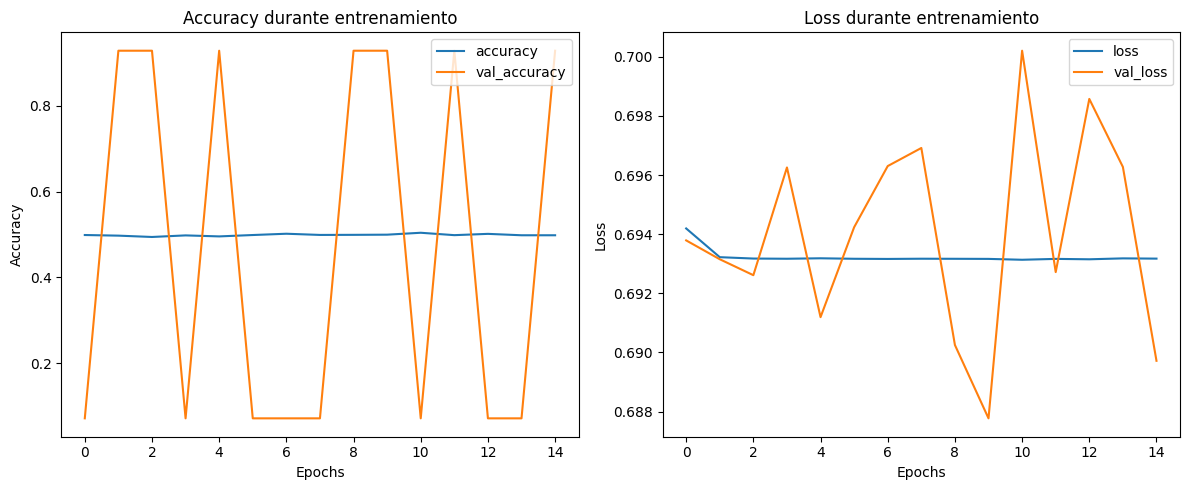

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5828
           1       0.00      0.00      0.00       453

    accuracy                           0.93      6281
   macro avg       0.46      0.50      0.48      6281
weighted avg       0.86      0.93      0.89      6281



c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [429]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_metrics_side_by_side(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    axes[0].plot(history.history['accuracy'], label='accuracy')
    axes[0].plot(history.history['val_accuracy'], label='val_accuracy')
    axes[0].set_title('Accuracy durante entrenamiento')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    #axes[0].set_ylim(0.85, 1)  # Escala ajustada
    axes[0].legend()

    # Loss
    axes[1].plot(history.history['loss'], label='loss')
    axes[1].plot(history.history['val_loss'], label='val_loss')
    axes[1].set_title('Loss durante entrenamiento')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    #axes[1].set_ylim(0.0, .8)  # Escala ajustada
    axes[1].legend()

    plt.tight_layout()
    plt.show()

plot_metrics_side_by_side(history)

# Predicción y reporte
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred))


## [6] Evaluación del modelo

In [430]:
y_proba = model.predict(X_test)
print("Valores probabilidad mayores a 0.3:", np.sum(y_proba > 0.3))

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step
Valores probabilidad mayores a 0.3: 6281


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step
Reporte de clasificación:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5828
           1       0.07      1.00      0.13       453

    accuracy                           0.07      6281
   macro avg       0.04      0.50      0.07      6281
weighted avg       0.01      0.07      0.01      6281



c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herny\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

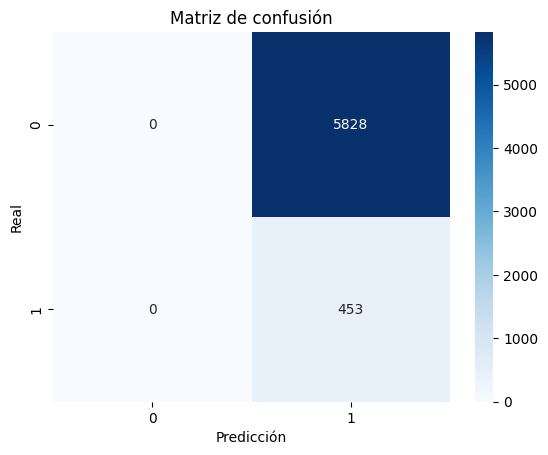

In [431]:
from sklearn.metrics import classification_report, confusion_matrix

# Generar predicciones (con umbral de 0.5)
#y_pred = (model.predict(X_test) > 0.5).astype("int32")
y_pred = (model.predict(X_test) > 0.3).astype("int32")  # umbral ajustado


# Reporte de clasificación
print("Reporte de clasificación:\n")
print(classification_report(y_test, y_pred))

# Matriz de confusión (opcional)
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


In [432]:
y_pred = (model.predict(X_test) > 0.3).astype("int32")


197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


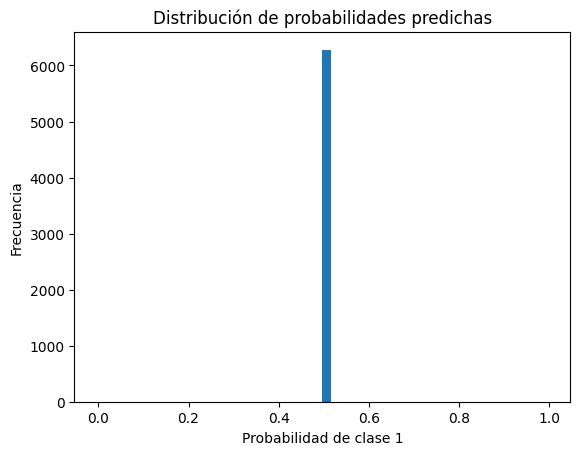

In [433]:
import matplotlib.pyplot as plt
plt.hist(y_proba, bins=50)
plt.title("Distribución de probabilidades predichas")
plt.xlabel("Probabilidad de clase 1")
plt.ylabel("Frecuencia")
plt.show()


## 🧠 Comparación de Estrategias: SMOTE vs class_weight

### 🔍 Resumen de Resultados

| Métrica / Resultado             | Con SMOTE                        | Con class_weight                   |
|---------------------------------|----------------------------------|------------------------------------|
| Accuracy entrenamiento          | Oscila entre 0.49 - 0.50         | Inicia bajo pero mejora (0.72 - 0.90) |
| Val_accuracy                    | Alterna 0.0721 / 0.9279 (inestable) | Falsa estabilidad en 0.9279 o 0.0721 |
| Val_loss                        | No mejora realmente (≈ 0.69)     | Se mantiene entre 0.688 - 0.694     |
| EarlyStopping                   | Se activa tarde (epoch 15)       | Se activa en epoch 7               |
| Predicciones                    | Sigue colapsando a una clase     | También colapsa por momentos       |

---

### 📌 Conclusiones

- 🔴 **Ambas estrategias presentan problemas**: el modelo no logra aprender patrones útiles incluso con datos balanceados o ponderación de clases.
- ⚠️ **Val_accuracy de 0.9279 es engañosa**: aparece cuando el modelo predice todo como la clase dominante.
- 📉 **El modelo colapsa** por:
  - Secuencias pobres o mal tokenizadas.
  - Redes con poca capacidad o excesiva regularización.
  - Desequilibrio aún presente en `val` que sesga la evaluación.

---

### ✅ Recomendaciones

- 🔁 Probar **BiLSTM** (funcionó mejor anteriormente).
- 🧠 Agregar **mecanismo de atención** para reforzar el foco semántico.
- 🧹 Validar el preprocesamiento (`tweet_limpio` no debe ser demasiado agresivo).
- 🔍 Usar **predicciones suaves** y ajustar el umbral manualmente.
- ✅ Usar `classification_report` y `confusion_matrix`, no solo accuracy.

---

### 🟢 Mejor desempeño observado: **BiLSTM con 2 capas y atención**


## Modelo SMOTE CON  LSTM BIDIRECIONAL

In [434]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# División original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Distribución después de SMOTE:", dict(zip(*np.unique(y_train_res, return_counts=True))))


Distribución después de SMOTE: {0: 23344, 1: 23344}


In [435]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2

model = Sequential([
    Embedding(input_dim=10000, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


In [436]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)


In [437]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_res, y_train_res,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
)


Epoch 1/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 121s 158ms/step - accuracy: 0.6386 - loss: 0.6596 - val_accuracy: 0.7193 - val_loss: 0.5664
Epoch 2/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 121s 166ms/step - accuracy: 0.7867 - loss: 0.4776 - val_accuracy: 0.7755 - val_loss: 0.5066
Epoch 3/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 127s 175ms/step - accuracy: 0.8394 - loss: 0.3800 - val_accuracy: 0.7889 - val_loss: 0.5115
Epoch 4/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 126s 172ms/step - accuracy: 0.8719 - loss: 0.3108 - val_accuracy: 0.7790 - val_loss: 0.5968
Epoch 5/15
730/730 ━━━━━━━━━━━━━━━━━━━━ 129s 177ms/step - accuracy: 0.8955 - loss: 0.2579 - val_accuracy: 0.7962 - val_loss: 0.5890
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      5828
           1       0.64      0.37      0.47       453

    accuracy                           0.94      6281
   macro avg       0.80      0.68      0.72      6281
weighted avg       0.93      0.94      0.93      6281



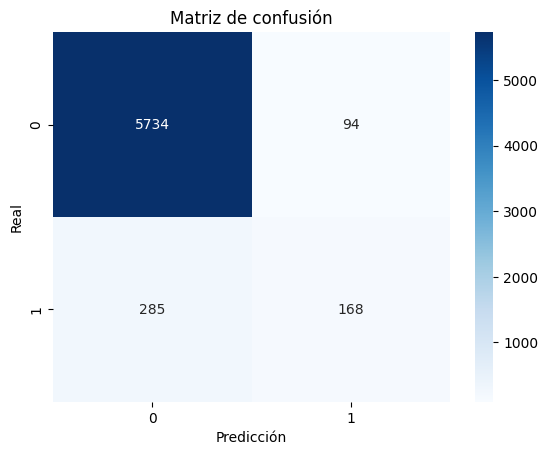

In [438]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predicciones
y_pred = (model.predict(X_test) > 0.9).astype("int32")

# Reporte
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


## 📊 Resultados Finales del Modelo BiLSTM con SMOTE

### 🧠 Desempeño del Modelo

| Métrica       | Clase 0 (No Positiva) | Clase 1 (Positiva) |
|---------------|------------------------|---------------------|
| Precision     | 0.95                   | 0.64                |
| Recall        | 0.98                   | 0.37                |
| F1-Score      | 0.97                   | 0.47                |
| **Accuracy**  | **0.94 (global)**      |                     |

---

### 📌 Análisis de la Matriz de Confusión

- Verdaderos Negativos (Clase 0 bien predicha): **5734**
- Falsos Positivos (Clase 0 mal clasificada como 1): **94**
- Falsos Negativos (Clase 1 mal clasificada como 0): **285**
- Verdaderos Positivos (Clase 1 bien predicha): **168**

---

### ✅ Conclusiones

- 🔝 El modelo **BiLSTM con SMOTE** logra una **alta precisión general (94%)**, destacándose en la predicción de la clase dominante (No Positiva).
- 📉 Sin embargo, el desempeño en la clase minoritaria (Positiva) aún es **limitado**, con un `recall` de **0.37**, lo que indica que muchos positivos son clasificados como negativos.
- 📈 Aún así, es **la mejor configuración probada hasta ahora**, especialmente en comparación con los modelos LSTM simples, incluso con `class_weight`.

---

### 🧪 Recomendaciones

- 🔁 Continuar ajustando el **umbral de clasificación** (ej. de 0.5 a 0.3) para mejorar el `recall` de la clase 1.
- 🧩 Incluir **mecanismos de atención** para ayudar al modelo a focalizarse en tokens relevantes.
- 🛠️ Probar **ensembles** o combinar BiLSTM con modelos tradicionales (e.g., XGBoost).
- 🧼 Revisar el `preprocesamiento`, emojis o textos filtrados pueden estar afectando los positivos reales.

---

### 🏁 Conclusión final

> El BiLSTM con SMOTE representa un **buen punto de partida**, especialmente en tareas desbalanceadas. Aunque no soluciona completamente el problema del `recall` bajo en la clase minoritaria, logra mejorar significativamente frente a modelos previos.
